# Telecom Churn Prediction


#### Problem Statement:

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate.
Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# work with plotly
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.subplots as tls # It's useful to we get some tools of plotly

from collections import Counter # To do counter of some features
import plotly.io as pio


# Supress warnings
warnings.filterwarnings('ignore')

## 1. Reading and Understanding the data

In [ ]:
# Reading the train data set

Telecom_df = pd.read_csv('train.csv')

In [ ]:
#Summary of the data set

Telecom_df.info(verbose=True,show_counts=True)

In [ ]:
#Percentage of churn in the current data

plt.title("Percentage of churn")
ax = Telecom_df["churn_probability"].value_counts().plot.bar(figsize=[8,6])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{round(height/len(Telecom_df["churn_probability"])*100, 2)}%', xy=(x + width/2, y + height*1.02), ha='center')
plt.show()

### Data Cleaning

In [ ]:
#Checking for unwanted rows

Telecom_df.head()

In [ ]:
Telecom_df.tail()

- There is no Incorrect rows - Header rows, footer rows
- There is no Summary rowsTotal, subtotal rows
- There is no Extra rows,Column numbers, indicators, blank rows

In [ ]:
for i in Telecom_df.columns:
    print(i)

- There is no missing columns observed
- There is no Inconsistent column names
- No Unique Identifier
- No Misaligned columns
- There is no Columns containing Multiple data values

### Dropping unwanted columns

In [ ]:
# Columns having same value across all records hence droping these

for i in Telecom_df.columns[Telecom_df.nunique() <= 1]:
    print(Telecom_df[i].value_counts())

In [ ]:
Telecom_df.shape

In [ ]:
# Dropping columns with signle value

DropCol = Telecom_df.columns[Telecom_df.nunique() <= 1].to_frame().index
Telecom_df.drop(DropCol,axis=1,inplace=True)

In [ ]:
Telecom_df.shape

In [ ]:
# 'Id' doesn't add any value since dropping the same

Telecom_df.drop(['id'],axis=1,inplace=True)

In [ ]:
# There are no duplicate records

Telecom_df[Telecom_df.duplicated()]

### Null value treatment

In [ ]:
# Checking for null values
obj = Telecom_df.isnull().sum()
for key,value in obj.iteritems():
    if value > 0 :
        print(key,",",value)

In [ ]:
# Checking the number of missing values and its percentage
missing_values_count = Telecom_df.isnull().sum().sort_values(ascending = False)
missing_values_perc = (100*Telecom_df.isnull().sum()/Telecom_df.shape[0]).sort_values(ascending = False)
df_missing_values = pd.concat([missing_values_count,missing_values_perc], axis=1, keys=['Missing Values', 'Missing Values %'])
df_missing_values[df_missing_values['Missing Values %']>0]

In [ ]:
#columns where we will impute missing values with zeroes

zero_impute = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8','av_rech_amt_data_6', 
               'av_rech_amt_data_7', 'av_rech_amt_data_8','max_rech_data_6', 'max_rech_data_7', 
               'max_rech_data_8','night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6',
              'fb_user_7','fb_user_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8',
              'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7',
               'count_rech_3g_8']

# impute missing values with 0
Telecom_df[zero_impute] = Telecom_df[zero_impute].apply(lambda x: x.fillna(0))

In [ ]:
#Columns where we will impute missing values with median
#All null values for onnet and offnet minutes of usage voice calls has been replaced 
#with median to keep the distribution

mou = ['onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8']
Telecom_df[mou] = Telecom_df[mou].apply(lambda x: x.fillna(x.median()))

In [ ]:
#Columns where we will impute missing values with median
#All null values for outgoing and incoming minutes of usage voice calls has been replaced 
#with median to keep the distribution
ogicarray = []
for i in Telecom_df.columns:
    if 'og' in i or 'ic' in i:
        ogicarray.append(i)
    
for i in ogicarray:
    print(i)
print(len(ogicarray))

Telecom_df[ogicarray] = Telecom_df[ogicarray].apply(lambda x: x.fillna(x.median()))

In [ ]:
# Handling dates columns
dates = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
         'date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']

In [ ]:
Telecom_df.info(verbose=True,show_counts=True)

### Outlier treatment

In [ ]:
NumCols = Telecom_df.select_dtypes(include=['int64','float64']).columns
NumCols

In [ ]:
fig, axs = plt.subplots(38,4,figsize=(25,250))
j=0
for i in NumCols:
    if(j>=4):
        k=j%4
    else:
        k=j
    sns.boxplot(Telecom_df[i],ax=axs[j//4][k])
    j+=1
fig.show()

In [ ]:
numeric_cols = []
for i in Telecom_df.columns[Telecom_df.nunique() > 3]:
    if('date' not in i ):
        numeric_cols.append(i)
print(len(numeric_cols))

In [ ]:
#Telecom_df1 = Telecom_df
#Telecom_df2 = Telecom_df

In [ ]:
#Telecom_df1.shape

for col in numeric_cols:
    q1 = Telecom_df[col].quantile(0.10)
    q3 = Telecom_df[col].quantile(0.90)
    iqr = q3-q1
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    print(col)
    print(low)
    print(high)
    Telecom_df1 = Telecom_df[(Telecom_df[col] > low) & (Telecom_df[col] < high)]

In [ ]:
#Telecom_df1.shape

In [ ]:
#Telecom_df2.shape

In [ ]:
#sns.boxplot(Telecom_df2['arpu_6'])

In [ ]:
#sns.boxplot(Telecom_df['arpu_6'])

In [ ]:
#Telecom_df2.info(verbose=True,show_counts=True)

In [ ]:
Telecom_df = Telecom_df[Telecom_df['arpu_6']<6000]
Telecom_df = Telecom_df[Telecom_df['arpu_7']<15000]
Telecom_df = Telecom_df[Telecom_df['arpu_8']<8000]

Telecom_df = Telecom_df[Telecom_df['offnet_mou_6']<6000]
Telecom_df = Telecom_df[Telecom_df['offnet_mou_7']<6000]
Telecom_df = Telecom_df[Telecom_df['offnet_mou_8']<6000]

Telecom_df = Telecom_df[Telecom_df['roam_ic_mou_6']<2500]
Telecom_df = Telecom_df[Telecom_df['roam_ic_mou_7']<2500]
Telecom_df = Telecom_df[Telecom_df['roam_ic_mou_8']<4000]

Telecom_df = Telecom_df[Telecom_df['roam_og_mou_6']<2500]
Telecom_df = Telecom_df[Telecom_df['roam_og_mou_7']<2500]
Telecom_df = Telecom_df[Telecom_df['roam_og_mou_7']<2500]

Telecom_df = Telecom_df[Telecom_df['loc_og_t2t_mou_6']<4500]
Telecom_df = Telecom_df[Telecom_df['loc_og_t2t_mou_7']<4500]
Telecom_df = Telecom_df[Telecom_df['loc_og_t2t_mou_8']<3800]

Telecom_df = Telecom_df[Telecom_df['loc_og_t2m_mou_6']<3000]
Telecom_df = Telecom_df[Telecom_df['loc_og_t2m_mou_7']<3000]
Telecom_df = Telecom_df[Telecom_df['loc_og_t2m_mou_8']<2300]

Telecom_df = Telecom_df[Telecom_df['loc_og_t2f_mou_6']<500]
Telecom_df = Telecom_df[Telecom_df['loc_og_t2f_mou_7']<400]
Telecom_df = Telecom_df[Telecom_df['loc_og_t2f_mou_8']<400]

Telecom_df = Telecom_df[Telecom_df['loc_og_t2c_mou_6']<170]
Telecom_df = Telecom_df[Telecom_df['loc_og_t2c_mou_7']<250]
Telecom_df = Telecom_df[Telecom_df['loc_og_t2c_mou_8']<250]

Telecom_df = Telecom_df[Telecom_df['loc_og_mou_6']<5000]
Telecom_df = Telecom_df[Telecom_df['loc_og_mou_7']<7000]
Telecom_df = Telecom_df[Telecom_df['loc_og_mou_8']<6000]

Telecom_df = Telecom_df[Telecom_df['std_og_t2t_mou_6']<5000]
Telecom_df = Telecom_df[Telecom_df['std_og_t2t_mou_7']<6000]
Telecom_df = Telecom_df[Telecom_df['std_og_t2t_mou_8']<6000]

Telecom_df = Telecom_df[Telecom_df['std_og_t2f_mou_6']<400]
Telecom_df = Telecom_df[Telecom_df['std_og_t2f_mou_7']<300]
Telecom_df = Telecom_df[Telecom_df['std_og_t2f_mou_8']<250]

Telecom_df = Telecom_df[Telecom_df['isd_og_mou_6']<1000]
Telecom_df = Telecom_df[Telecom_df['isd_og_mou_8']<800]

Telecom_df = Telecom_df[Telecom_df['spl_og_mou_6']<500]
Telecom_df = Telecom_df[Telecom_df['spl_og_mou_7']<500]
Telecom_df = Telecom_df[Telecom_df['spl_og_mou_8']<600]

Telecom_df = Telecom_df[Telecom_df['og_others_6']<30]
Telecom_df = Telecom_df[Telecom_df['og_others_7']<15]
Telecom_df = Telecom_df[Telecom_df['og_others_8']<12]

##########################################################

#Telecom_df = Telecom_df[Telecom_df['loc_ic_t2t_mou_6']<4500]
Telecom_df = Telecom_df[Telecom_df['loc_ic_t2t_mou_7']<4500]
Telecom_df = Telecom_df[Telecom_df['loc_ic_t2t_mou_8']<4500]

#Telecom_df = Telecom_df[Telecom_df['loc_ic_t2m_mou_6']<3000]
#Telecom_df = Telecom_df[Telecom_df['loc_ic_t2m_mou_7']<3000]
Telecom_df = Telecom_df[Telecom_df['loc_ic_t2m_mou_8']<4000]

Telecom_df = Telecom_df[Telecom_df['loc_ic_t2f_mou_6']<1200]
Telecom_df = Telecom_df[Telecom_df['loc_ic_t2f_mou_7']<1200]
Telecom_df = Telecom_df[Telecom_df['loc_ic_t2f_mou_8']<1200]

Telecom_df = Telecom_df[Telecom_df['loc_ic_mou_6']<6000]
Telecom_df = Telecom_df[Telecom_df['loc_ic_mou_7']<6000]
Telecom_df = Telecom_df[Telecom_df['loc_ic_mou_8']<8000]

#Telecom_df = Telecom_df[Telecom_df['std_ic_t2t_mou_6']<5000]
Telecom_df = Telecom_df[Telecom_df['std_ic_t2t_mou_7']<2500]
Telecom_df = Telecom_df[Telecom_df['std_ic_t2t_mou_8']<2500]

Telecom_df = Telecom_df[Telecom_df['std_ic_t2m_mou_6']<3000]
Telecom_df = Telecom_df[Telecom_df['std_ic_t2m_mou_7']<4000]
Telecom_df = Telecom_df[Telecom_df['std_ic_t2m_mou_8']<3500]

Telecom_df = Telecom_df[Telecom_df['std_ic_t2f_mou_6']<800]
Telecom_df = Telecom_df[Telecom_df['std_ic_t2f_mou_7']<600]
Telecom_df = Telecom_df[Telecom_df['std_ic_t2f_mou_8']<600]

Telecom_df = Telecom_df[Telecom_df['isd_ic_mou_6']<4000]
Telecom_df = Telecom_df[Telecom_df['isd_ic_mou_7']<4000]
Telecom_df = Telecom_df[Telecom_df['isd_ic_mou_8']<3000]

Telecom_df = Telecom_df[Telecom_df['spl_ic_mou_6']<1]
Telecom_df = Telecom_df[Telecom_df['spl_ic_mou_7']<1.25]
Telecom_df = Telecom_df[Telecom_df['spl_ic_mou_8']<1.25]

Telecom_df = Telecom_df[Telecom_df['ic_others_6']<600]
Telecom_df = Telecom_df[Telecom_df['ic_others_7']<500]
Telecom_df = Telecom_df[Telecom_df['ic_others_8']<800]

#############################################################################

Telecom_df = Telecom_df[Telecom_df['total_rech_num_6']<100]
Telecom_df = Telecom_df[Telecom_df['total_rech_num_6']<90]
Telecom_df = Telecom_df[Telecom_df['total_rech_num_6']<100]

Telecom_df = Telecom_df[Telecom_df['max_rech_amt_6']<2500]
Telecom_df = Telecom_df[Telecom_df['max_rech_amt_7']<2500]
Telecom_df = Telecom_df[Telecom_df['max_rech_amt_8']<2500]

Telecom_df = Telecom_df[Telecom_df['last_day_rch_amt_6']<2500]
Telecom_df = Telecom_df[Telecom_df['last_day_rch_amt_7']<1250]
Telecom_df = Telecom_df[Telecom_df['last_day_rch_amt_8']<2500]

Telecom_df = Telecom_df[Telecom_df['total_rech_data_6']<35]
#Telecom_df = Telecom_df[Telecom_df['total_rech_data_7']<500]
#Telecom_df = Telecom_df[Telecom_df['total_rech_data_8']<800]

Telecom_df = Telecom_df[Telecom_df['max_rech_data_6']<1000]
Telecom_df = Telecom_df[Telecom_df['max_rech_data_7']<1000]
Telecom_df = Telecom_df[Telecom_df['max_rech_data_8']<1000]

Telecom_df = Telecom_df[Telecom_df['count_rech_2g_6']<35]
Telecom_df = Telecom_df[Telecom_df['count_rech_2g_7']<30]
Telecom_df = Telecom_df[Telecom_df['count_rech_2g_8']<35]

Telecom_df = Telecom_df[Telecom_df['count_rech_3g_6']<25]
Telecom_df = Telecom_df[Telecom_df['count_rech_3g_7']<25]
Telecom_df = Telecom_df[Telecom_df['count_rech_3g_8']<30]

Telecom_df = Telecom_df[Telecom_df['av_rech_amt_data_6']<2500]
Telecom_df = Telecom_df[Telecom_df['av_rech_amt_data_7']<2500]
Telecom_df = Telecom_df[Telecom_df['av_rech_amt_data_8']<2500]

Telecom_df = Telecom_df[Telecom_df['vol_2g_mb_6']<8000]
Telecom_df = Telecom_df[Telecom_df['vol_2g_mb_7']<6000]
Telecom_df = Telecom_df[Telecom_df['vol_2g_mb_8']<8000]

Telecom_df = Telecom_df[Telecom_df['vol_3g_mb_6']<15000]
Telecom_df = Telecom_df[Telecom_df['vol_3g_mb_7']<15000]
Telecom_df = Telecom_df[Telecom_df['vol_3g_mb_8']<14000]

Telecom_df = Telecom_df[Telecom_df['arpu_2g_6']<3000]
Telecom_df = Telecom_df[Telecom_df['arpu_2g_7']<2000]
Telecom_df = Telecom_df[Telecom_df['arpu_2g_8']<2000]

Telecom_df = Telecom_df[Telecom_df['arpu_3g_6']<2500]
Telecom_df = Telecom_df[Telecom_df['arpu_3g_7']<2000]
Telecom_df = Telecom_df[Telecom_df['arpu_3g_8']<2000]


In [ ]:
#Telecom_df2.shape

In [ ]:
fig, axs = plt.subplots(38,4,figsize=(25,250))
j=0
for i in NumCols:
    if(j>=4):
        k=j%4
    else:
        k=j
    sns.boxplot(Telecom_df[i],ax=axs[j//4][k])
    j+=1
fig.show()

In [ ]:
Telecom_df.info(verbose=True,show_counts=True)

### Deriving new features

## 2. Exploratory Data Analysis/Data Visualization

In [ ]:
#Percentage of churn in the current data

plt.title("Percentage of churn")
ax = Telecom_df["churn_probability"].value_counts().plot.bar(figsize=[8,6])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{round(height/len(Telecom_df["churn_probability"])*100, 2)}%', xy=(x + width/2, y + height*1.02), ha='center')
plt.show()

### Univariate Analysis

In [ ]:
# quantitative variables
print(len(numeric_cols))

In [ ]:
sns.histplot(Telecom_df['arpu_6'])

In [ ]:
sns.distplot(Telecom_df['arpu_6'])

In [ ]:
ogCols = []
icCols = []
dataCols = []
otherCols = []
for i in numeric_cols:
    if 'og' in i:
        ogCols.append(i)
    elif 'ic' in i:
        icCols.append(i)
    elif 'data' in i or '2g' in i or '3g' in i:
        dataCols.append(i)
    else:
        otherCols.append(i)

print(len(ogCols))
print(len(icCols))
print(len(dataCols))
print(len(otherCols))
    

In [ ]:
#count_rech_2g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(25,5))
Telecom_df.count_rech_2g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.count_rech_2g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.count_rech_2g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('count_rech_2g_6')
axs[1].set_xlabel('count_rech_2g_7')
axs[2].set_xlabel('count_rech_2g_8')
fig.show()

In [ ]:
#count_rech_3g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(25,5))
Telecom_df.count_rech_3g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.count_rech_3g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.count_rech_3g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('count_rech_3g_6')
axs[1].set_xlabel('count_rech_3g_7')
axs[2].set_xlabel('count_rech_3g_8')
fig.show()

- Number of people using 2g seems to be more than 3g as per the above graphs
- Number of people using 2g or 3g across 3 months are almost similar

In [ ]:
#total_rech_data across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(25,5))
Telecom_df.total_rech_data_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.total_rech_data_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.total_rech_data_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('total_rech_data_6')
axs[1].set_xlabel('total_rech_data_7')
axs[2].set_xlabel('total_rech_data_8')
fig.show()

- Total reacharge data is similar across all 3 months

In [ ]:
#max_rech_data across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df.max_rech_data_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.max_rech_data_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.max_rech_data_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('max_rech_data_6')
axs[1].set_xlabel('max_rech_data_7')
axs[2].set_xlabel('max_rech_data_8')
fig.show()

In [ ]:
#av_rech_amt_data across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df.av_rech_amt_data_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.av_rech_amt_data_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.av_rech_amt_data_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('av_rech_amt_data_6')
axs[1].set_xlabel('av_rech_amt_data_7')
axs[2].set_xlabel('av_rech_amt_data_8')
fig.show()

In [ ]:
Telecom_df.av_rech_amt_data_6.value_counts()

In [ ]:
#vol_2g_mb across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df.vol_2g_mb_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.vol_2g_mb_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.vol_2g_mb_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('vol_2g_mb_6')
axs[1].set_xlabel('vol_2g_mb_7')
axs[2].set_xlabel('vol_2g_mb_8')
fig.show()

In [ ]:
#vol_3g_mb across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df.vol_3g_mb_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.vol_3g_mb_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.vol_3g_mb_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('vol_3g_mb_6')
axs[1].set_xlabel('vol_3g_mb_7')
axs[2].set_xlabel('vol_3g_mb_8')
fig.show()

In [ ]:
#monthly_2g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df.monthly_2g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.monthly_2g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.monthly_2g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('monthly_2g_6')
axs[1].set_xlabel('monthly_2g_7')
axs[2].set_xlabel('monthly_2g_8')
fig.show()

In [ ]:
#monthly_3g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df.monthly_3g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.monthly_3g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.monthly_3g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('monthly_3g_6')
axs[1].set_xlabel('monthly_3g_7')
axs[2].set_xlabel('monthly_g_8')
fig.show()

In [ ]:
#arpu_2g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df.arpu_2g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.arpu_2g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.arpu_2g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('arpu_2g_6')
axs[1].set_xlabel('arpu_2g_7')
axs[2].set_xlabel('arpu_2g_8')
fig.show()

In [ ]:
#arpu_3g across months 6,7 and 8
fig, axs = plt.subplots(1,3,figsize=(35,10))
Telecom_df.arpu_3g_6.sort_values().value_counts().plot.bar(ax = axs[0])
Telecom_df.arpu_3g_7.sort_values().value_counts().plot.bar(ax = axs[1])
Telecom_df.arpu_3g_8.sort_values().value_counts().plot.bar(ax = axs[2])
axs[0].set_xlabel('arpu_3g_6')
axs[1].set_xlabel('arpu_3g_7')
axs[2].set_xlabel('arpu_3g_8')
fig.show()

- Number of users regarging for max amount 25,17,23 increased for month 7 and 8 compared to amount 154,198 ...

In [ ]:
tr0 = go.Bar(
            x = Telecom_df[Telecom_df["churn_probability"]== 1]["churn_probability"].value_counts().index.values,
            y = Telecom_df[Telecom_df["churn_probability"]== 1]["churn_probability"].value_counts().values,
            name='Churned'
    )

tr1 = go.Bar(
            x = Telecom_df[Telecom_df["churn_probability"]== 0]["churn_probability"].value_counts().index.values,
            y = Telecom_df[Telecom_df["churn_probability"]== 0]["churn_probability"].value_counts().values,
            name='Not Churned'
    )

data = [tr0, tr1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='churn_probability Variable'
    ),
    title='Chrun probability variable distribution'
)

fig = go.Figure(data=data, layout=layout)


py.iplot(fig, filename='grouped-bar')

In [ ]:
sns.pairplot(Telecom_df[''])
plt.show()

In [ ]:
sns.pairplot(Telecom_df[icCols])
plt.show()

In [ ]:
sns.pairplot(Telecom_df[dataCols])
plt.show()

In [ ]:
sns.pairplot(Telecom_df[otherCols])
plt.show()

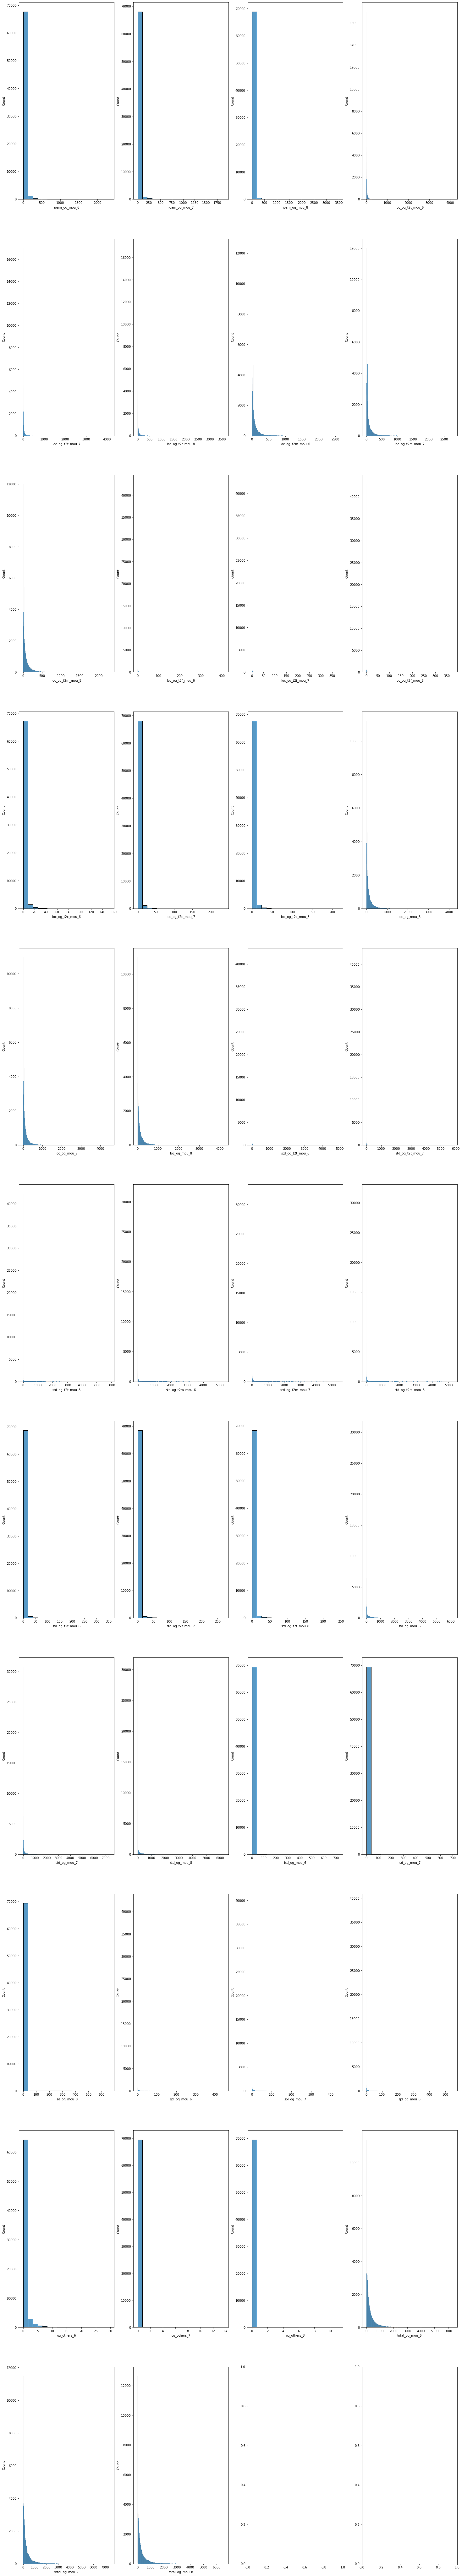

In [43]:
fig, axs = plt.subplots(11,4,figsize=(25,150))
j=0
for i in ogCols:
    if(j>=4):
        k=j%4
    else:
        k=j
    sns.histplot(Telecom_df[i],ax=axs[j//4][k])
    j+=1
fig.show()